<a href="https://colab.research.google.com/github/armx97/ANR_UDA_project1/blob/main/Social_Media_Disasters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Набор данных


**Набор данных**

Наш набор данных: бедствия в социальных сетях
Участники просмотрели более 10 000 твитов, полученных с помощью различных поисковых запросов, таких как “пылающий”, “карантин” и “столпотворение”, затем отметили, относится ли твит к событию бедствия.

Почему это имеет значение

Мы постараемся правильно предсказать твиты, посвященные бедствиям. Это очень актуальная проблема, потому что:

Это применимо к любому, кто пытается получить сигнал от шума (например, в данном случае к полицейским управлениям).
Это сложно, потому что полагаться на ключевые слова сложнее, чем в большинстве случаев, например, на спам

In [1]:
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

**Sanitizing input**

Дезинфицирующий ввод

Убедимся, что в ваших твитах есть только нужные нам символы. Удаляем символы "#", но сохраняем слова после знака "#", потому что они могут иметь отношение к делу (например: #катастрофа)

In [2]:
input_file = codecs.open("/content/drive/MyDrive/Учеба/Магистратура 2 курс/Анализ неструктурных данных/Project/socialmedia_relevant_cols.csv", "r",encoding='utf-8', errors='replace')
output_file = open("/content/drive/MyDrive/Учеба/Магистратура 2 курс/Анализ неструктурных данных/Project/socialmedia_relevant_cols_clean.csv", "w")

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
sanitize_characters(input_file, output_file)

## Проверка данных

Нам не нужны URL-адреса, и мы хотели бы, чтобы все наши слова были в нижнем регистре (Привет и ПРИВЕТ довольно похожи для нашей задачи)

In [3]:
questions = pd.read_csv("/content/drive/MyDrive/Учеба/Магистратура 2 курс/Анализ неструктурных данных/Project/socialmedia_relevant_cols_clean.csv")
questions.columns=['text', 'choose_one', 'class_label']
questions.head()

text choose_one  class_label
0                 Just happened a terrible car crash   Relevant            1
1  Our Deeds are the Reason of this #earthquake M...   Relevant            1
2  Heard about #earthquake is different cities, s...   Relevant            1
3  there is a forest fire at spot pond, geese are...   Relevant            1
4             Forest fire near La Ronge Sask. Canada   Relevant            1

In [4]:
questions.tail()

text  ... class_label
10362  ??Water fight??\r\nPenn park 6pm \r\n      BYO...  ...           0
10363  Abe proposed a new plan for abolishing nuclear...  ...           0
10364  Your Router is One of the Latest DDoS Attack W...  ...           0
10365  @eyecuts @Erasuterism I love 96 Gal Deco to de...  ...           1
10366    #Battlefield 1942 forgotten hope secret weapons  ...           1

[5 rows x 3 columns]

In [5]:
questions.describe()

class_label
count  10367.000000
mean       0.426739
std        0.497738
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        2.000000

## Очистка данных

Используем несколько регулярных выражений для очистки данных и сохраним их обратно на диск для дальнейшего использования

In [6]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

text choose_one  class_label
0                 just happened a terrible car crash   Relevant            1
1  our deeds are the reason of this  earthquake m...   Relevant            1
2  heard about  earthquake is different cities, s...   Relevant            1
3  there is a forest fire at spot pond, geese are...   Relevant            1
4             forest fire near la ronge sask  canada   Relevant            1

In [7]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

Unnamed: 0  ... class_label
10362       10362  ...           0
10363       10363  ...           0
10364       10364  ...           0
10365       10365  ...           1
10366       10366  ...           1

[5 rows x 4 columns]

## Обзор данных

Посмотрим на наш классовый баланс.

In [8]:
clean_questions.groupby("class_label").count()

Unnamed: 0  text  choose_one
class_label                              
0                  5959  5959        5959
1                  4392  4392        4392
2                    16    16          16

Наши классы довольно сбалансированы, с небольшой избыточной выборкой "Нерелевантного" класса.

**Наши данные чисты, теперь их необходимо подготовить**

Преобразуем наши исходные данные таким образом, чтобы наша модель могла их понять. Это подразумевает:

Обозначение предложений списком отдельных слов
Создание разделения теста поезда
Еще немного проверим наши данные, чтобы подтвердить результаты

## Токенизировка текста

In [9]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

Unnamed: 0  ...                                             tokens
0           0  ...          [just, happened, a, terrible, car, crash]
1           1  ...  [our, deeds, are, the, reason, of, this, earth...
2           2  ...  [heard, about, earthquake, is, different, citi...
3           3  ...  [there, is, a, forest, fire, at, spot, pond, g...
4           4  ...      [forest, fire, near, la, ronge, sask, canada]

[5 rows x 5 columns]

**Немного подробное изучение набора данных**

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

147473 words total, with a vocabulary size of 17648
Max sentence length is 34


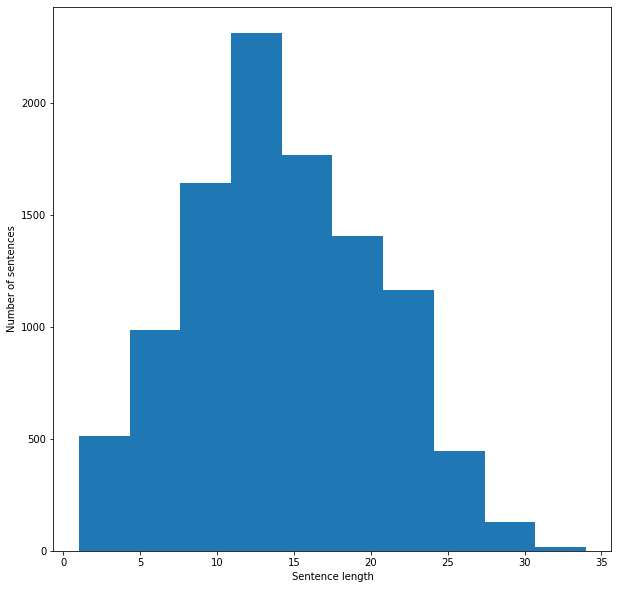

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

# One-hot encoding <<Мешок слов>>




**Переход к машинному обучению**

Теперь, когда наши данные очищены и подготовлены,переходим к части машинного обучения.

**Enter embeddings**

Машинное обучение на изображениях может использовать необработанные пиксели в качестве входных данных. Алгоритмы обнаружения мошенничества могут использовать функции клиентов.

Естественным способом представления текста для компьютеров является кодирование каждого символа по отдельности, что кажется совершенно недостаточным для представления и понимания языка. Наша цель состоит в том, чтобы сначала создать полезное встраивание для каждого предложения (или твита) в нашем наборе данных, а затем использовать эти встраивания для точного прогнозирования соответствующей категории.

Самый простой подход, с которого мы можем начать, - это использовать модель "мешок слов" и применить сверху логистическую регрессию. Пакет слов просто связывает индекс с каждым словом в нашем словаре и включает каждое предложение в виде списка из 0, с 1 в каждом индексе, соответствующем слову, присутствующему в предложении.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)



Теперь, когда мы создали вложения, визуализируем их и посмотрим, сможем ли мы определить какую-то структуру. В идеальном мире наши вложения были бы настолько различны, что эти два класса были бы идеально разделены. Поскольку визуализировать данные в размерах 20 кб сложно, уменьшим их до 2.

## Визуализация векторных представлений



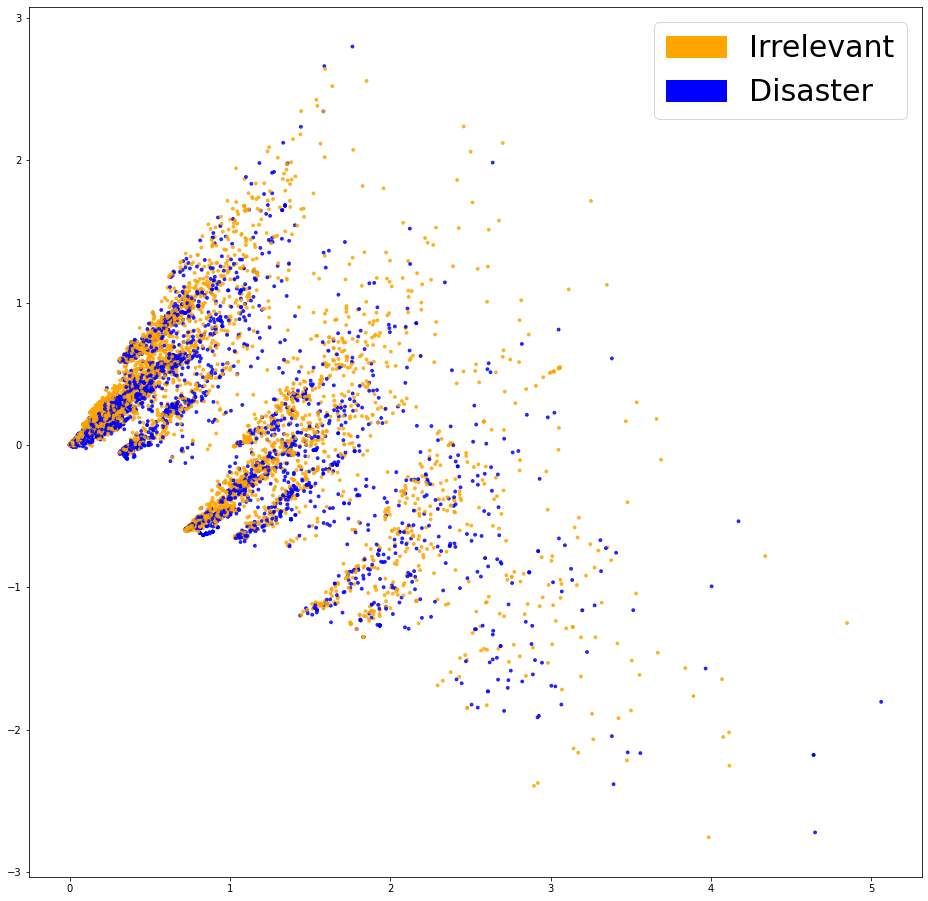

In [13]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)

Эти вложения выглядят не очень четко разделенными. Посмотрим, сможем ли мы все еще установить на них полезную модель.

**Установка классификатора**

Начать с логистической регрессии - хорошая идея. Он прост, часто выполняет свою работу и легко поддается интерпретации.

In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

## Оценка

Давайте начнем с рассмотрения некоторых показателей, чтобы понять, хорошо ли вообще работает наш классификатор.

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.761, precision = 0.759, recall = 0.761, f1 = 0.759


Метрика - это одно, но для того, чтобы принять действенное решение, нам нужно на самом деле проверить, какие ошибки допускает наш классификатор. Давайте начнем с рассмотрения матрицы сопряженности.

In [16]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

## Проверка - Confusion matrix

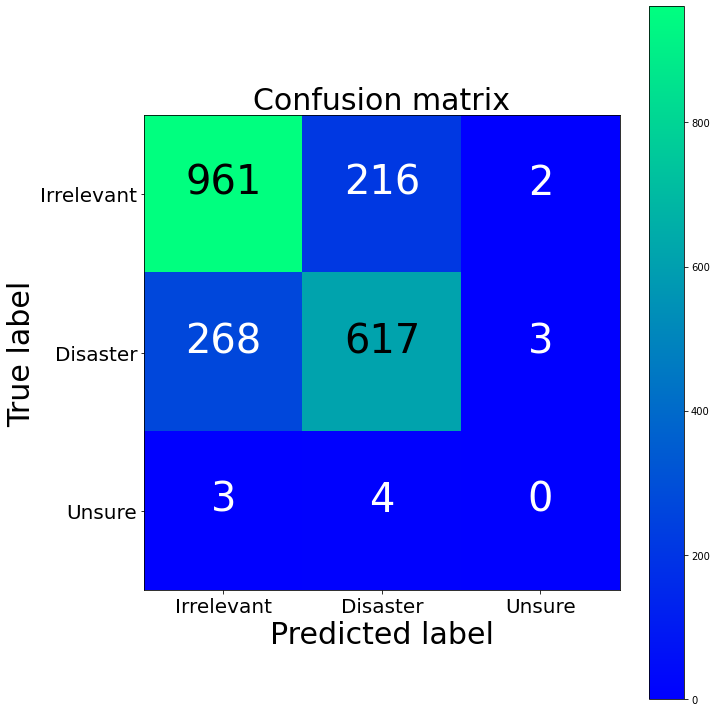

[[961 216   2]
 [268 617   3]
 [  3   4   0]]


In [17]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

Наш классификатор никогда не предсказывает класс 3, что неудивительно, учитывая, что он критически занижен. Здесь это не очень важно, так как ярлык не очень значим. Наш классификатор создает больше ложноотрицательных результатов, чем ложноположительных (пропорционально). В зависимости от варианта использования это кажется желательным (например, ложное срабатывание - довольно высокая стоимость для правоохранительных органов).

**Дальнейшая проверка**

Давайте посмотрим на функции, которые наш классификатор использует для принятия решений.

In [18]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

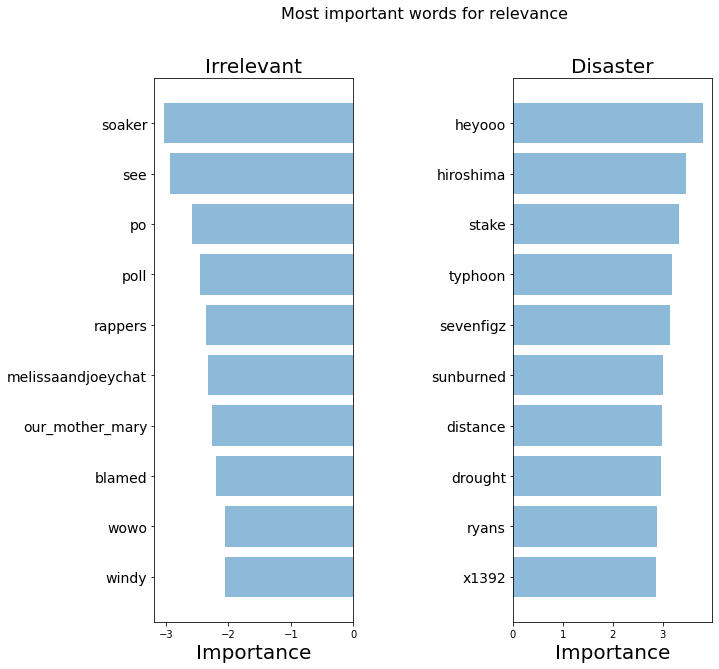

In [19]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# TF-IDF

Наш классификатор правильно улавливает некоторые закономерности (хиросима, массовая резня), но явно переоценивает некоторые устаревшие термины (heyoo, x1392).

**TF IDF Мешок слов**

Попробуем немного более тонкий подход. В дополнение к нашей модели набора слов мы используем TF-IDF (Частота терминов, обратная частота документов), что означает взвешивание слов по частоте их появления в нашем наборе данных, отбрасывание слишком частых слов, поскольку они просто добавляют шума.



In [20]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## Визуализация векторных представлений

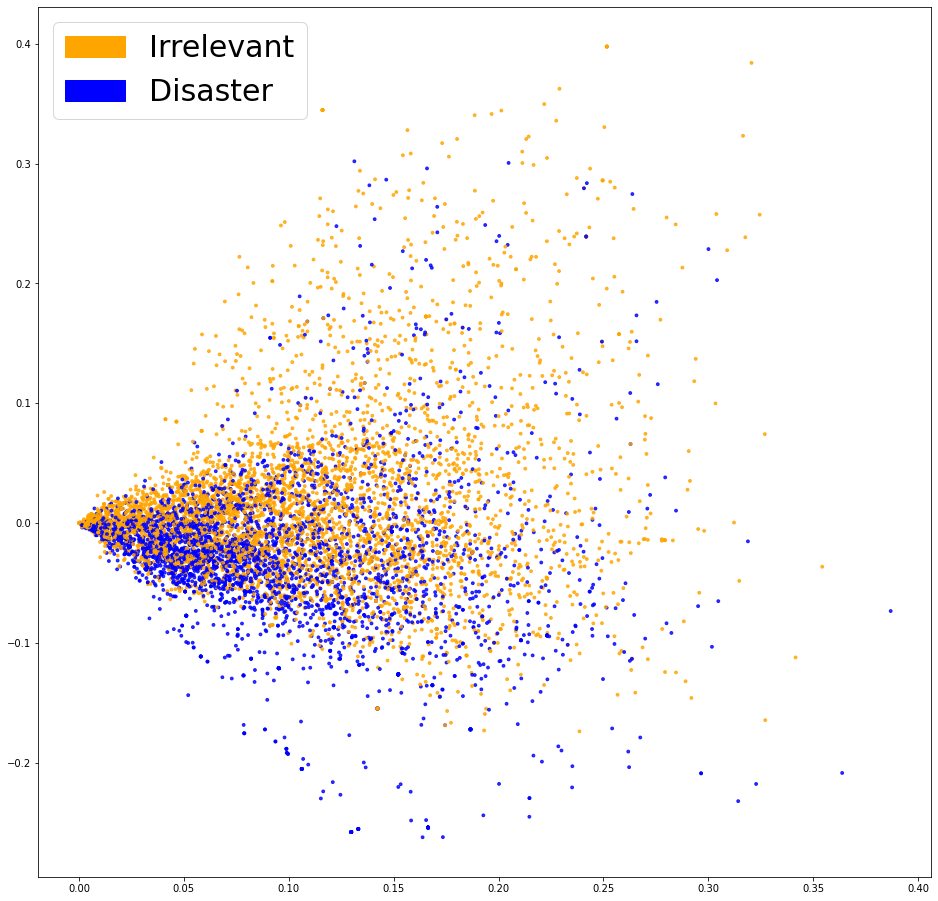

In [21]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

## Оценка

Эти встраивания выглядят гораздо более разделенными, давайте посмотрим, приведет ли это к повышению производительности.

In [22]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

## Проверка - Confusion matrix

In [23]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.768, precision = 0.765, recall = 0.768, f1 = 0.766


Результаты немного лучше, давайте посмотрим, приведут ли они к реальной разнице в нашем случае использования.



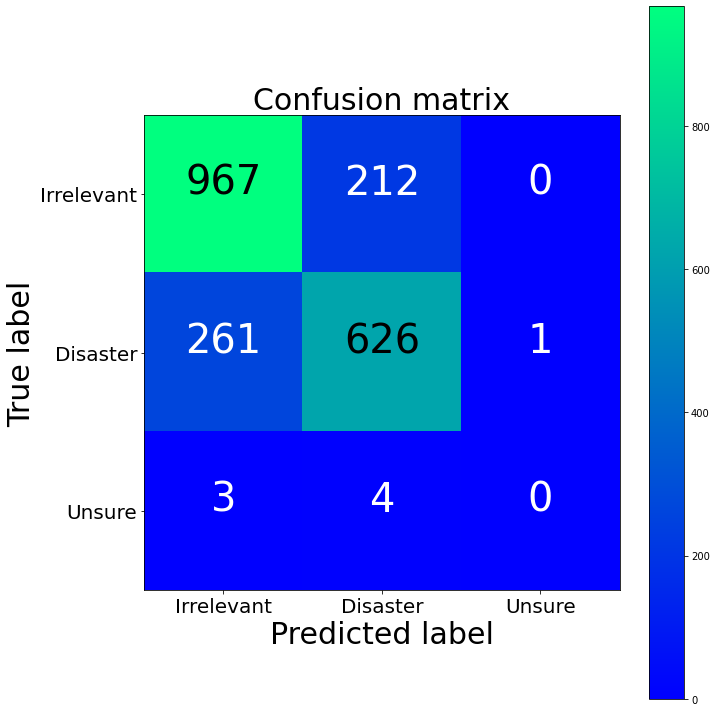

TFIDF confusion matrix
[[967 212   0]
 [261 626   1]
 [  3   4   0]]
BoW confusion matrix
[[961 216   2]
 [268 617   3]
 [  3   4   0]]


In [24]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

**Анализ важных коэффициентов для линейной регрессии**

Наши ложные срабатывания уменьшились, так как эта модель более консервативна в выборе положительного класса.

In [25]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

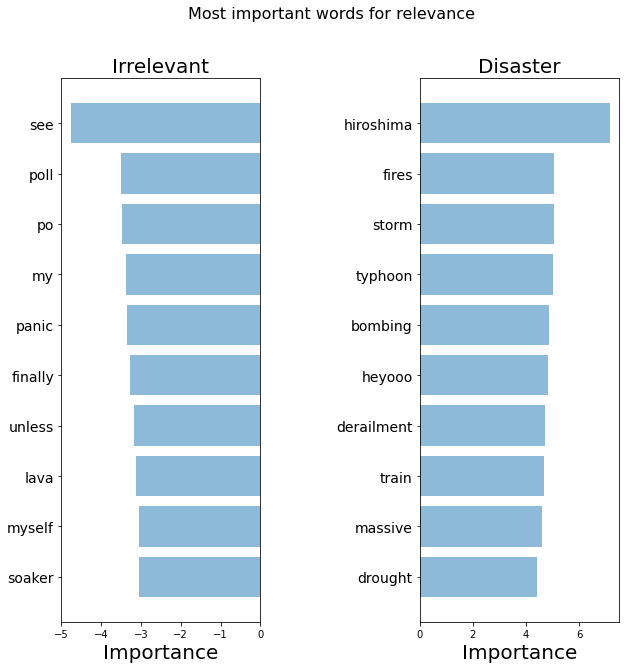

In [26]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# Применение семантики

## Word2vec

Слова, которые он подобрал, выглядят гораздо более уместными! Хотя наши показатели в нашем расширенном наборе проверок не сильно возросли, мы гораздо больше уверены в терминах, используемых нашей моделью, и, следовательно, чувствовали бы себя более комфортно, развертывая ее в системе, которая будет взаимодействовать с клиентами.

Улавливание семантического значения

Наши первые модели сумели уловить слова с высоким сигналом. Однако маловероятно, что у нас будет обучающий набор, содержащий все соответствующие слова. Чтобы решить эту проблему, нам нужно уловить семантическое значение слов. Это означает, что мы должны понимать, что такие слова, как "хороший" и "позитивный", ближе, чем абрикос и "континент".

**word2vec**

Word2vec - это модель, которая была предварительно обучена на очень большом корпусе и обеспечивает встраивания, которые отображают слова, похожие друг на друга. Быстрый способ получить встраивание предложения для нашего классификатора - это усреднить баллы word2vec по всем словам в нашем предложении.

In [29]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [30]:
import gensim
from gensim import models
# Load Google's pre-trained Word2Vec model.
word2vec_path = "~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [31]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [32]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

### Визуализация векторных представлений

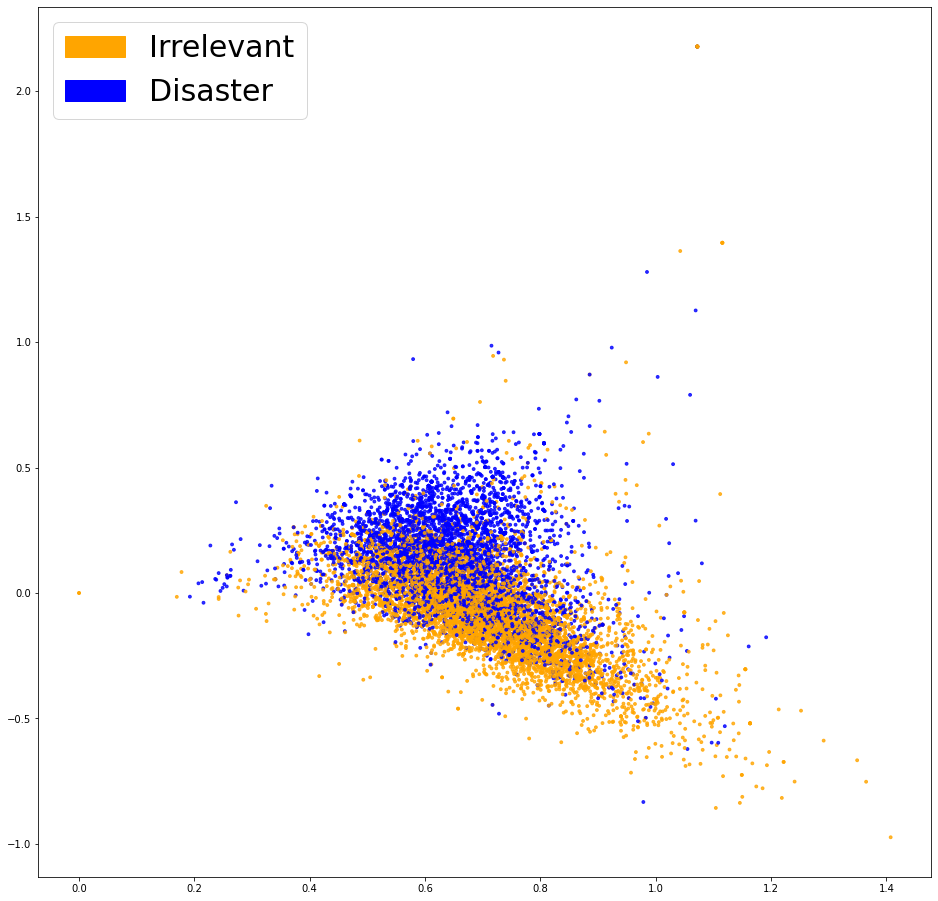

In [33]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

Они выглядят гораздо более разделенными, давайте посмотрим, как на них действует наша логистическая регрессия

### Оценка

In [34]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

### Проверка - Confusion matrix

In [35]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.778, precision = 0.780, recall = 0.778, f1 = 0.779


Все еще становится лучше, давайте построим матрицу сопряженности

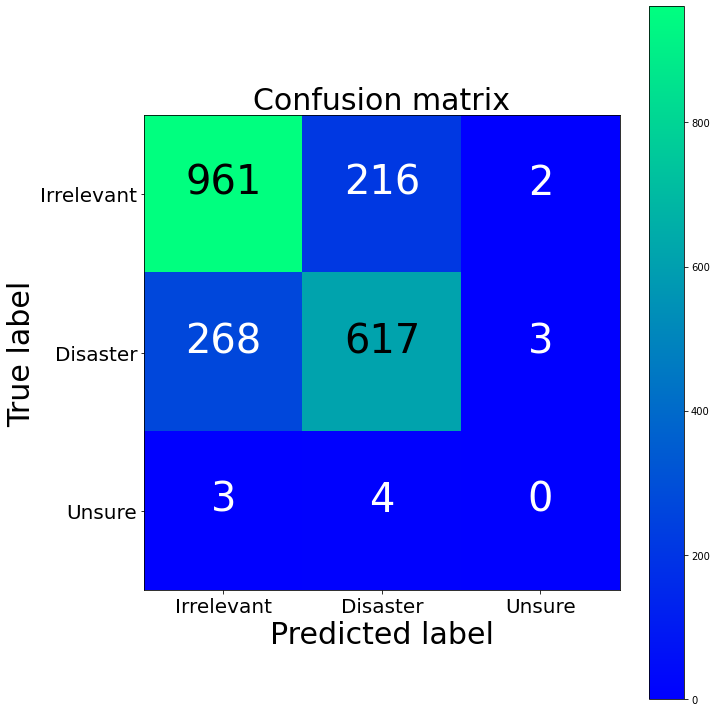

Word2Vec confusion matrix
[[942 229   8]
 [213 671   4]
 [  2   5   0]]
TFIDF confusion matrix
[[967 212   0]
 [261 626   1]
 [  3   4   0]]
BoW confusion matrix
[[961 216   2]
 [268 617   3]
 [  3   4   0]]


In [36]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Наша модель строго лучше во всех отношениях, чем первые две модели, это многообещающе!

**Дальнейшая проверка**

Поскольку в нашей модели не используется вектор с одним измерением на слово, становится намного сложнее напрямую определить, какие слова наиболее соответствуют нашей классификации. Чтобы обеспечить некоторую объяснимость, мы можем использовать объясненный черный ящик, такой как LIME.

In [37]:
pip install lime

     |████████████████████████████████| 275 kB 5.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=2a401b632662e36f6a8eacfd40eb8ad4bba0a7ad2a8e42464aa8d1d4cf04098b
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [38]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [39]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["irrelevant","relevant", "unknown"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

### Визуализация результатов модели (LIME)

In [40]:
visualize_one_exp(X_test_data, y_test_data, 65)


Index: 65
True class: irrelevant


In [41]:
visualize_one_exp(X_test_data, y_test_data, 60)


Index: 60
True class: irrelevant


In [42]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant',
    2: 'Unsure'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


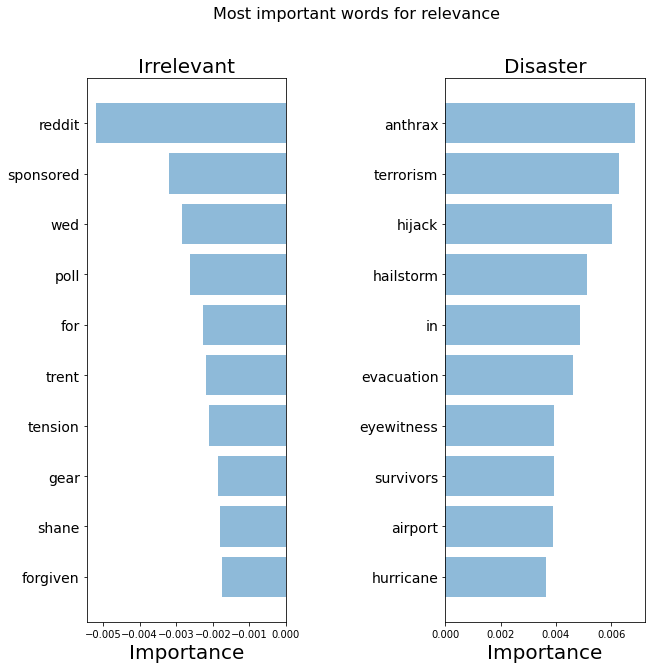

In [43]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")